In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from IPython.display import display
pd.set_option('max_rows', 5)
pd.set_option('max_columns', 9)
%matplotlib inline

# 特徴選択
---
データセットに存在する特徴から、モデル構築に使用する特徴を一部に絞り込むこと。  
利用する特徴を減らすことで、ストレージ・メモリの使用量を減らしたり、モデルを早く動かせる。また、データ理解という観点からは同程度の精度ならばより少ない特徴で記述したほうが理解しやすくなる。

正則化が適用できないモデルでは過学習の防止に役立つが、正則化が適用できるモデルでは**過学習防止には正則化**を用いる。

## 評価指標に基づくもの

### ステップワイズ法
---
評価指標が改善する特徴を追加・削除していく。

評価指標には AIC (Akaike's Information Criterion, 赤池情報量規準) や BIC (Bayesian Information Criterion, ベイズ情報量規準) を用いることが多い。 (モデルの複雑さと精度のバランスをとるため)  
絞り込みたい特徴の数が決まっている場合には他の一般的な評価指標 (accuracy や MSE など) も利用される。

#### forward stepwise selection
---
最も評価指標を改善する特徴を 1 つずつ追加。

##### Pythonによるforward stepwise selectionの実行方法
---
`mlxtend.feature_selection.SequentialFeatureSelector`を使用する。

In [2]:
loader = load_boston()
boston = pd.DataFrame(np.column_stack([loader.data, loader.target]),
                      columns=list(loader.feature_names) + ['target'])
print('boston')
display(boston)

boston


,CRIM,ZN,INDUS,CHAS,...,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,...,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,...,17.8,396.90,9.14,21.6
...,...,...,...,...,...,...,...,...,...
504,0.10959,0.0,11.93,0.0,...,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,...,21.0,396.90,7.88,11.9


In [3]:
x = boston.iloc[:, :-1]
y = boston.iloc[:, -1]
model = LinearRegression()

In [4]:
help(SequentialFeatureSelector)

Help on class SequentialFeatureSelector in module mlxtend.feature_selection.sequential_feature_selector:

class SequentialFeatureSelector(mlxtend.utils.base_compostion._BaseXComposition, sklearn.base.MetaEstimatorMixin)
 |  SequentialFeatureSelector(estimator, k_features=1, forward=True, floating=False, verbose=0, scoring=None, cv=5, n_jobs=1, pre_dispatch='2*n_jobs', clone_estimator=True, fixed_features=None)
 |  
 |  Sequential Feature Selection for Classification and Regression.
 |  
 |  Parameters
 |  ----------
 |  estimator : scikit-learn classifier or regressor
 |  k_features : int or tuple or str (default: 1)
 |      Number of features to select,
 |      where k_features < the full feature set.
 |      New in 0.4.2: A tuple containing a min and max value can be provided,
 |          and the SFS will consider return any feature combination between
 |          min and max that scored highest in cross-validtion. For example,
 |          the tuple (1, 4) will return any combination

In [5]:
fs = SequentialFeatureSelector(model, k_features=5, n_jobs=-1)
fs.fit(x, y)
fs.k_feature_names_

('CRIM', 'CHAS', 'RM', 'PTRATIO', 'LSTAT')

In [6]:
fs.subsets_

{1: {'feature_idx': (12,),
  'cv_scores': array([0.31784807, 0.5406078 , 0.07608699, 0.42423767, 0.1267687 ]),
  'avg_score': 0.2971098460066865,
  'feature_names': ('LSTAT',)},
 2: {'feature_idx': (10, 12),
  'cv_scores': array([0.47872024, 0.55896066, 0.29416107, 0.44039936, 0.37716673]),
  'avg_score': 0.4298816135857271,
  'feature_names': ('PTRATIO', 'LSTAT')},
 3: {'feature_idx': (3, 10, 12),
  'cv_scores': array([0.5125899 , 0.52887883, 0.31209504, 0.47271838, 0.37935597]),
  'avg_score': 0.4411276233882674,
  'feature_names': ('CHAS', 'PTRATIO', 'LSTAT')},
 4: {'feature_idx': (3, 5, 10, 12),
  'cv_scores': array([0.74342797, 0.68528955, 0.55392829, 0.20544105, 0.02541525]),
  'avg_score': 0.4427004222330956,
  'feature_names': ('CHAS', 'RM', 'PTRATIO', 'LSTAT')},
 5: {'feature_idx': (0, 3, 5, 10, 12),
  'cv_scores': array([0.74205803, 0.69167982, 0.55264435, 0.19713656, 0.06081025]),
  'avg_score': 0.4488658019850355,
  'feature_names': ('CRIM', 'CHAS', 'RM', 'PTRATIO', 'LSTAT'

#### backward stepwise selection
---
最も評価指標に影響しない特徴を 1 つずつ削除。

##### Pythonによるbackward stepwise selectionの実行方法
---
`mlxtend.feature_selection.SequentialFeatureSelector`の引数`forward=False`にする。

In [7]:
bs = SequentialFeatureSelector(model,
                               k_features=x.columns.size - 2,
                               forward=False,
                               n_jobs=-1)
bs.fit(x, y)
bs.k_feature_names_

('CRIM',
 'ZN',
 'CHAS',
 'NOX',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT')

In [8]:
bs.subsets_

{13: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
  'cv_scores': array([ 0.63919994,  0.71386698,  0.58702344,  0.07923081, -0.25294154]),
  'avg_score': 0.3532759243958797,
  'feature_names': ('CRIM',
   'ZN',
   'INDUS',
   'CHAS',
   'NOX',
   'RM',
   'AGE',
   'DIS',
   'RAD',
   'TAX',
   'PTRATIO',
   'B',
   'LSTAT')},
 12: {'feature_idx': (0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12),
  'cv_scores': array([0.46450601, 0.61522064, 0.43616681, 0.57879898, 0.37296639]),
  'avg_score': 0.4935317652178909,
  'feature_names': ('CRIM',
   'ZN',
   'INDUS',
   'CHAS',
   'NOX',
   'AGE',
   'DIS',
   'RAD',
   'TAX',
   'PTRATIO',
   'B',
   'LSTAT')},
 11: {'feature_idx': (0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12),
  'cv_scores': array([0.46910347, 0.66682374, 0.43729546, 0.5814138 , 0.37173933]),
  'avg_score': 0.5052751616354444,
  'feature_names': ('CRIM',
   'ZN',
   'CHAS',
   'NOX',
   'AGE',
   'DIS',
   'RAD',
   'TAX',
   'PTRATIO',
   'B',
   'LSTAT')}}

### permutation importance
---
ある特徴の値をランダムに並べ替えて、元のデータでの評価指標と並べ替えたデータでの評価指標の差によって特徴の重要度を決定する。

<table class="border text-center">
    <tr class="border-none background-default">
        <th colspan="3">元データ</th>
        <th rowspan="7"></th>
        <th colspan="3">特徴Aの評価用</th>
        <th rowspan="7"></th>
        <th colspan="3">特徴Bの評価用</th>
        <th rowspan="7"></th>
        <th colspan="3">特徴Cの評価用</th>
    </tr>
    <tr>
        <th>特徴A</th>
        <th>特徴B</th>
        <th>特徴C</th>
        <th>特徴A</th>
        <th>特徴B</th>
        <th>特徴C</th>
        <th>特徴A</th>
        <th>特徴B</th>
        <th>特徴C</th>
        <th>特徴A</th>
        <th>特徴B</th>
        <th>特徴C</th>
    </tr>
    <tr>
        <td>$A_{1}$</td>
        <td>$B_{1}$</td>
        <td>$C_{1}$</td>
        <td>$A_{2}$</td>
        <td>$B_{1}$</td>
        <td>$C_{1}$</td>
        <td>$A_{1}$</td>
        <td>$B_{3}$</td>
        <td>$C_{1}$</td>
        <td>$A_{1}$</td>
        <td>$B_{1}$</td>
        <td>$C_{3}$</td>
    </tr>
    <tr>
        <td>$A_{2}$</td>
        <td>$B_{2}$</td>
        <td>$C_{2}$</td>
        <td>$A_{3}$</td>
        <td>$B_{2}$</td>
        <td>$C_{2}$</td>
        <td>$A_{2}$</td>
        <td>$B_{1}$</td>
        <td>$C_{2}$</td>
        <td>$A_{2}$</td>
        <td>$B_{2}$</td>
        <td>$C_{1}$</td>
    </tr>
    <tr>
        <td>$A_{3}$</td>
        <td>$B_{3}$</td>
        <td>$C_{3}$</td>
        <td>$A_{1}$</td>
        <td>$B_{3}$</td>
        <td>$C_{3}$</td>
        <td>$A_{3}$</td>
        <td>$B_{2}$</td>
        <td>$C_{3}$</td>
        <td>$A_{3}$</td>
        <td>$B_{3}$</td>
        <td>$C_{2}$</td>
    </tr>
    <tr class="border-none background-default">
        <td colspan="3">↓</td>
        <td colspan="3">↓</td>
        <td colspan="3">↓</td>
        <td colspan="3">↓</td>
    </tr>
    <tr class="border-none background-default">
        <td colspan="3">$accuracy$</td>
        <td colspan="3">$accuracy_{A}$</td>
        <td colspan="3">$accuracy_{B}$</td>
        <td colspan="3">$accuracy_{C}$</td>
    </tr>
</table>

#### Pythonによるpermutation importanceの実行方法
---
`sklearn.inspection.permutation_importance`を使用する。

In [9]:
help(permutation_importance)

Help on function permutation_importance in module sklearn.inspection._permutation_importance:

permutation_importance(estimator, X, y, *, scoring=None, n_repeats=5, n_jobs=None, random_state=None)
    Permutation importance for feature evaluation [BRE]_.
    
    The :term:`estimator` is required to be a fitted estimator. `X` can be the
    data set used to train the estimator or a hold-out set. The permutation
    importance of a feature is calculated as follows. First, a baseline metric,
    defined by :term:`scoring`, is evaluated on a (potentially different)
    dataset defined by the `X`. Next, a feature column from the validation set
    is permuted and the metric is evaluated again. The permutation importance
    is defined to be the difference between the baseline metric and metric from
    permutating the feature column.
    
    Read more in the :ref:`User Guide <permutation_importance>`.
    
    Parameters
    ----------
    estimator : object
        An estimator that has 

In [10]:
model.fit(x, y)
permutation_importance(model, x, y, n_jobs=-1, random_state=1234)

{'importances_mean': array([ 1.96611776e-02,  2.88784136e-02,  5.17942896e-04,  1.16984535e-02,
         9.51127766e-02,  1.65389569e-01, -3.92127478e-05,  2.22342246e-01,
         1.68006784e-01,  9.81300283e-02,  1.05044328e-01,  1.44056929e-02,
         3.33326050e-01]),
 'importances_std': array([2.82530773e-03, 3.24397080e-03, 3.71467778e-04, 3.73854063e-03,
        7.05170892e-03, 1.46838030e-02, 5.54020404e-05, 1.58087709e-02,
        1.38840358e-02, 8.67227171e-03, 1.26760553e-02, 4.40860777e-03,
        2.45306602e-02]),
 'importances': array([[ 2.02354023e-02,  2.03645514e-02,  2.34847108e-02,
          1.47171653e-02,  1.95040583e-02],
        [ 2.45676015e-02,  2.85112681e-02,  3.46400809e-02,
          2.85761550e-02,  2.80969625e-02],
        [ 8.86440184e-04,  4.26798509e-04, -5.70749560e-05,
          9.59090491e-04,  3.74460251e-04],
        [ 9.26068758e-03,  1.35827993e-02,  1.81064411e-02,
          7.72482256e-03,  9.81751722e-03],
        [ 8.34655791e-02,  1.0469

## モデルの性質に基づくもの
---
モデルによっては学習後に特徴の重要性を表す情報が得られるので、それを活用して特徴を選択する。

### Lasso回帰
---
[L1 正則化](regularization.ipynb#L1%E6%AD%A3%E5%89%87%E5%8C%96)を用いる Lasso 回帰は、係数が 0 になった特徴は重要でないと考えられるので、特徴選択に利用可能。

### ランダム・フォレスト (random forest)
---
一部の特徴のみ (サンプルも一部のみの場合あり) を使って学習した複数の決定木の多数決や平均値で予測する手法。集団学習 (アンサンブル学習) の中のバギング (bagging) の代表的手法。

<table class="border text-center">
    <tr class="border-none background-default">
        <th colspan="4">決定木1</th>
        <td rowspan="5"></td>
        <th colspan="4">決定木2</th>
        <td rowspan="5"></td>
        <th colspan="4">決定木3</th>
    </tr>
    <tr>
        <th class="border-top-none border-right-bold background-default"></th>
        <th class="background-dark text-red">特徴A</th>
        <th class="background-dark text-red">特徴B</th>
        <th class="background-dark">特徴C</th>
        <th class="border-top-none border-right-bold background-default"></th>
        <th class="background-dark">特徴A</th>
        <th class="background-dark text-red">特徴B</th>
        <th class="background-dark text-red">特徴C</th>
        <th class="border-top-none border-right-bold background-default"></th>
        <th class="background-dark text-red">特徴A</th>
        <th class="background-dark">特徴B</th>
        <th class="background-dark text-red">特徴C</th>
    </tr>
    <tr class="background-bright">
        <th class="border-bottom border-right-bold text-red background-dark">サンプル1</th>
        <td class="text-red">利用</td>
        <td class="text-red">利用</td>
        <td>不使用</td>
        <th class="border-bottom border-right-bold text-red background-dark">サンプル1</th>
        <td>不使用</td>
        <td class="text-red">利用</td>
        <td class="text-red">利用</td>
        <th class="border-bottom border-right-bold background-dark">サンプル1</th>
        <td>不使用</td>
        <td>不使用</td>
        <td>不使用</td>
    </tr>
    <tr class="background-bright">
        <th class="border-bottom border-right-bold text-red background-dark">サンプル2</th>
        <td class="text-red">利用</td>
        <td class="text-red">利用</td>
        <td>不使用</td>
        <th class="border-bottom border-right-bold background-dark">サンプル2</th>
        <td>不使用</td>
        <td>不使用</td>
        <td>不使用</td>
        <th class="border-bottom border-right-bold text-red background-dark">サンプル2</th>
        <td class="text-red">利用</td>
        <td>不使用</td>
        <td class="text-red">利用</td>
    </tr>
    <tr class="background-bright">
        <th class="border-bottom border-right-bold background-dark">サンプル3</th>
        <td>不使用</td>
        <td>不使用</td>
        <td>不使用</td>
        <th class="border-bottom border-right-bold text-red background-dark">サンプル3</th>
        <td>不使用</td>
        <td class="text-red">利用</td>
        <td class="text-red">利用</td>
        <th class="border-bottom border-right-bold text-red background-dark">サンプル3</th>
        <td class="text-red">利用</td>
        <td>不使用</td>
        <td class="text-red">利用</td>
    </tr>
</table>

#### 他の手法との比較
---
[決定木](decision_tree.ipynb)は、十分な深さがあればほぼ全てのサンプルを完璧に分類できる代わりに汎化性能が著しく低くなる高バリアンスなモデル。ランダムフォレストは、一部の特徴・一部のサンプルだけを使った決定木を多数構築し、それらの決定木の多数決で予測することで汎化性能を高める。ただし、決定木のような結果に対する説明力はない。

Lasso 回帰は説明変数と目的変数の関係が線形であることを前提にしているが、ランダム・フォレストは決定木を用いるので線形な関係でなくともよい。

#### 仕組み
---
scikit-learn の実装では、その特徴が分岐条件に使われた際の (そのノードに到達するサンプルの割合で加重された) 不純度の平均的な減少量によって特徴の重要度を決定する。

多重共線性 (特徴の相関が高い) などの場合には、一方の重要度が高く、他方が低くなることもあるが、特徴選択に用いるだけならそれほど問題ない。

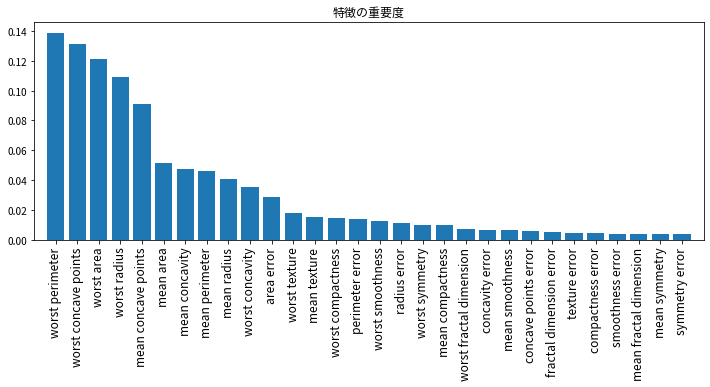

In [11]:
from my_functions.feature_selection import rf_feature_importance
rf_feature_importance.show()

#### Pythonでのランダム・フォレストによる特徴選択の実行方法
---
`sklearn.ensemble.RandomForestClassifier`や`sklearn.ensemble.RandomForestRegressor`を学習させた後、`feature_importances_`属性を参照する。

In [12]:
loader = load_breast_cancer()
cancer = pd.DataFrame(np.column_stack([loader.data, loader.target]),
                      columns=list(loader.feature_names) + ['target'])
print('cancer')
display(cancer)

cancer


,mean radius,mean texture,mean perimeter,mean area,...,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,...,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,...,0.1860,0.2750,0.08902,0.0
...,...,...,...,...,...,...,...,...,...
567,20.60,29.33,140.10,1265.0,...,0.2650,0.4087,0.12400,0.0
568,7.76,24.54,47.92,181.0,...,0.0000,0.2871,0.07039,1.0


In [13]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  P

In [14]:
x = cancer.iloc[:, :-1]
y = cancer.iloc[:, -1]
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1234)
rf.fit(x, y)
rf.feature_importances_

array([0.0572391 , 0.01818295, 0.04976017, 0.03476067, 0.00546018,
       0.00846855, 0.05699552, 0.08295488, 0.00533678, 0.00325888,
       0.00600567, 0.005381  , 0.00951609, 0.03304585, 0.00503519,
       0.00529307, 0.00619566, 0.00701214, 0.00314792, 0.00486091,
       0.11535804, 0.01681525, 0.16187602, 0.10815229, 0.01282889,
       0.01485554, 0.02634281, 0.11694055, 0.01228586, 0.00663357])

In [15]:
x.columns[np.argsort(rf.feature_importances_)[::-1]]

Index(['worst perimeter', 'worst concave points', 'worst radius', 'worst area',
       'mean concave points', 'mean radius', 'mean concavity',
       'mean perimeter', 'mean area', 'area error', 'worst concavity',
       'mean texture', 'worst texture', 'worst compactness',
       'worst smoothness', 'worst symmetry', 'perimeter error',
       'mean compactness', 'concave points error', 'worst fractal dimension',
       'concavity error', 'radius error', 'mean smoothness', 'texture error',
       'mean symmetry', 'compactness error', 'smoothness error',
       'fractal dimension error', 'mean fractal dimension', 'symmetry error'],
      dtype='object')

### recursive feature elimination
---
重み (パラメーター) の大きさが変数の重要度を表すモデルや`feature_importances_`属性を持つモデルを学習させ、重要度の小さい特徴から 1 つずつ削除。

#### Pythonでのrecursive feature eliminationの実行方法
---
`sklearn.feature_selection.RFE`を使用する。利用可能なモデルは`coef_`または`feature_importances_`属性を持つもの。

In [16]:
print('boston')
display(boston)

boston


,CRIM,ZN,INDUS,CHAS,...,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,...,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,...,17.8,396.90,9.14,21.6
...,...,...,...,...,...,...,...,...,...
504,0.10959,0.0,11.93,0.0,...,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,...,21.0,396.90,7.88,11.9


In [17]:
help(RFE)

Help on class RFE in module sklearn.feature_selection._rfe:

class RFE(sklearn.feature_selection._base.SelectorMixin, sklearn.base.MetaEstimatorMixin, sklearn.base.BaseEstimator)
 |  RFE(estimator, *, n_features_to_select=None, step=1, verbose=0)
 |  
 |  Feature ranking with recursive feature elimination.
 |  
 |  Given an external estimator that assigns weights to features (e.g., the
 |  coefficients of a linear model), the goal of recursive feature elimination
 |  (RFE) is to select features by recursively considering smaller and smaller
 |  sets of features. First, the estimator is trained on the initial set of
 |  features and the importance of each feature is obtained either through a
 |  ``coef_`` attribute or through a ``feature_importances_`` attribute.
 |  Then, the least important features are pruned from current set of features.
 |  That procedure is recursively repeated on the pruned set until the desired
 |  number of features to select is eventually reached.
 |  
 |  Rea

In [18]:
x = boston.iloc[:, :-1]
y = boston.iloc[:, -1]
model = LinearRegression()
rfe = RFE(model, n_features_to_select=1)
rfe.fit(x, y)
rfe.ranking_

array([ 8, 10,  9,  3,  1,  2, 13,  5,  7, 11,  4, 12,  6])

In [19]:
x.columns[np.argsort(rfe.ranking_)]

Index(['NOX', 'RM', 'CHAS', 'PTRATIO', 'DIS', 'LSTAT', 'RAD', 'CRIM', 'INDUS',
       'ZN', 'TAX', 'B', 'AGE'],
      dtype='object')

### その他の手法
---
勾配ブースティングという手法を実装した[LightGBM](https://lightgbm.readthedocs.io/en/latest/)や[xgboost](https://xgboost.readthedocs.io/en/latest/)は欠損値があっても動作し、ランダム・フォレストのように`feature_importances_`で特徴の重要度が参照できる。

`LightGBM`の使用例

In [20]:
model_lgbm = LGBMRegressor(random_state=1234)
model_lgbm.fit(x, y)
model_lgbm.feature_importances_

array([207,  14,  69,  11, 138, 269, 216, 253,  49,  79,  99, 185, 293],
      dtype=int32)

In [21]:
x.columns[np.argsort(model_lgbm.feature_importances_)[::-1]]

Index(['LSTAT', 'RM', 'DIS', 'AGE', 'CRIM', 'B', 'NOX', 'PTRATIO', 'TAX',
       'INDUS', 'RAD', 'ZN', 'CHAS'],
      dtype='object')

`xgboost`の使用例

In [22]:
model_xgb = XGBRegressor(random_state=1234)
model_xgb.fit(x, y)
model_xgb.feature_importances_

array([0.01778572, 0.00137419, 0.01510167, 0.00365362, 0.0518821 ,
       0.23821141, 0.00902774, 0.04952978, 0.01097363, 0.03895662,
       0.04516473, 0.00857165, 0.50976723], dtype=float32)

In [23]:
x.columns[np.argsort(model_xgb.feature_importances_)[::-1]]

Index(['LSTAT', 'RM', 'NOX', 'DIS', 'PTRATIO', 'TAX', 'CRIM', 'INDUS', 'RAD',
       'AGE', 'B', 'CHAS', 'ZN'],
      dtype='object')

## 推薦図書
---
- [Python 機械学習プログラミング 達人データサイエンティストによる理論と実践](https://www.amazon.co.jp/Python-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0-%E9%81%94%E4%BA%BA%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%83%86%E3%82%A3%E3%82%B9%E3%83%88%E3%81%AB%E3%82%88%E3%82%8B%E7%90%86%E8%AB%96%E3%81%A8%E5%AE%9F%E8%B7%B5-impress-gear/dp/4295003379/)
- [Kaggleで勝つデータ分析の技術](https://www.amazon.co.jp/Kaggle%E3%81%A7%E5%8B%9D%E3%81%A4%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90%E3%81%AE%E6%8A%80%E8%A1%93-%E9%96%80%E8%84%87-%E5%A4%A7%E8%BC%94/dp/4297108437/)
- [Pythonではじめる機械学習 ―scikit-learnで学ぶ特徴量エンジニアリングと機械学習の基礎](https://www.amazon.co.jp/Python%E3%81%A7%E3%81%AF%E3%81%98%E3%82%81%E3%82%8B%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92-%E2%80%95scikit-learn%E3%81%A7%E5%AD%A6%E3%81%B6%E7%89%B9%E5%BE%B4%E9%87%8F%E3%82%A8%E3%83%B3%E3%82%B8%E3%83%8B%E3%82%A2%E3%83%AA%E3%83%B3%E3%82%B0%E3%81%A8%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AE%E5%9F%BA%E7%A4%8E-Andreas-C-Muller/dp/4873117984/)